In [37]:
from pymoo.core.algorithm import Algorithm
from sklearn.gaussian_process import GaussianProcessRegressor
from numpy.random import uniform
from numpy import argmax
from numpy import vstack
from pymoo.core.initialization import Initialization
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.repair import NoRepair
from pymoo.core.population import Population
from scipy.stats import norm


#The optimization process itself is as follows:

# 1. Define the black box function f(x), the acquisition function a(x) 
# and the search space of the parameter x.

# 2. Generate some initial values of x randomly, and measure the corresponding outputs from f(x).
# 3. Fit a Gaussian process model m(X, y) onto X = x and y = f(x). 
# In other words, m(X, y) serves as a surrogate model for f(x)!

# 4. The acquisition function a(x) then uses m(X, y) to generate new values of x as follows. 
# Use m(X, y) to predict how f(x) varies with x. 
# The value of x which leads to the largest predicted value in m(X, y) is then suggested 
# as the next sample of x to evaluate with f(x).

# 5. Repeat the optimization process in steps 3 and 4 until we finally 
# get a value of x that leads to the global optimum of f(x). 
# Note that all historical values of x and f(x) should be used to train 
# the Gaussian process model m(X, y) in the next iteration — as the number 
# of data points increases, m(X, y) becomes better at predicting the optimum of f(x).

class BayesianOptimiztion(Algorithm):
    def __init__(self,
                 sample_size = 1000, # The number of samples to be generated from the problems and 
                                    #used in the acquisition function
                 sampling=FloatRandomSampling(),        
                 repair=NoRepair(),
                 model = GaussianProcessRegressor(),# the surrogate model to be used in the optimization
                 **kwargs):
        
        super().__init__(**kwargs)

        self.sample_size = sample_size
        self.initialization = Initialization(sampling)
        self.model = model
        self.repair = repair
        #the data set to be used in the optimization
        self.data_set_X = None
        self.data_set_Y = None

    
        
    def _setup(self, problem, **kwargs):
        self.model = GaussianProcessRegressor()
    
    def _initialize_infill(self):
        return self.initialization.do(self.problem, self.sample_size, algorithm=self)
        #print("initial_pop X",initial_pop.get("X"))
        #print("initial_pop F",self.problem.evaluate(initial_pop.get("X")))

    def _initialize_advance(self, infills=None, **kwargs):
        self.data_set_X = self.pop.get("X")
        self.data_set_Y = self.problem.evaluate(self.data_set_X)
        #print(self.data_set_X)
        #print(self.data_set_Y)
        self.update_model(self.data_set_X,self.data_set_Y)

        super()._initialize_advance(infills=infills, **kwargs)

    def _infill(self):
        for _ in range(1):
            X_new = self.optimize_acquisition_function()
            self.update_data_set(X_new)
            self.update_model(self.data_set_X,self.data_set_Y)

        off = Population.new(X=self.data_set_X)
        self.pop = off
        return off
        
    
    def _advance(self, infills=None, **kwargs):
        self.update_model(self.data_set_X,self.data_set_Y)
    
    def _finalize(self):
        return super()._finalize()
    
    # define the surrogate function
    def surrogate_function(self,X):
        return self.model.predict(X, return_std=True)

    # sample from the search space
    def sample(self):
        if self.problem.has_bounds():
            xl, xu = self.problem.bounds()
            X = uniform(xl, xu, size=(self.sample_size, self.problem.n_var))
            return X
        
    
    # define the acquisition function   
    def optimize_acquisition_function(self):
        if self.problem.has_bounds():
            # Randomly draw 100 sample points from the search space
            X_sample = self.sample()
            # calculate the current best surrogate score 
            predicted_y, _ = self.surrogate_function(self.data_set_X)
            current_best = min(predicted_y)
            
            # calculate mean and std of the sample in the surrogate function
            mu_sample, std_sample = self.surrogate_function(X_sample)
            mu_sample = mu_sample[:,0]

            # calculate the probability of improvement
            probability_of_improvement = self.find_probability_of_improvement(mu_sample, std_sample, current_best)
            #print("predicted_y",len(predicted_y))
            #print("mu_sample",mu_sample)
            #print("predicted_y",predicted_y)
            #print("current_best",current_best)
            #print("pi",mu_sample - current_best / (std_sample + 1**-16))
            # calculate the expected improvement
            expected_improvement = -((mu_sample - current_best) * probability_of_improvement + std_sample * norm.pdf(mu_sample - current_best / (std_sample + 1**-16)))
         
            #print("expected_improvement",expected_improvement)
            # find the index of the greatest scores
            #print("pi",pi)
            index = argmax(expected_improvement)
            print("std",std_sample)
            #print("probability_of_improvement",mu_sample[index])
            #print("index", index)
            return X_sample[index, :]
    
    def find_probability_of_improvement(self, mean, std, current_best):
        return norm.cdf(-(mean - current_best - 0.3) / (std + 1**-16))
    
    # update the model with new samples
    def update_model(self, X, Y):
        self.model.fit(X, Y)

    # optimize the acquisition function
    def update_data_set(self, X_new):
        # update the model with new samples
        self.data_set_X = vstack((self.data_set_X, X_new))
        self.data_set_Y = vstack((self.data_set_Y, self.problem.evaluate(X_new)))
        #print("data_setY",min(self.data_set_Y))
    

std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

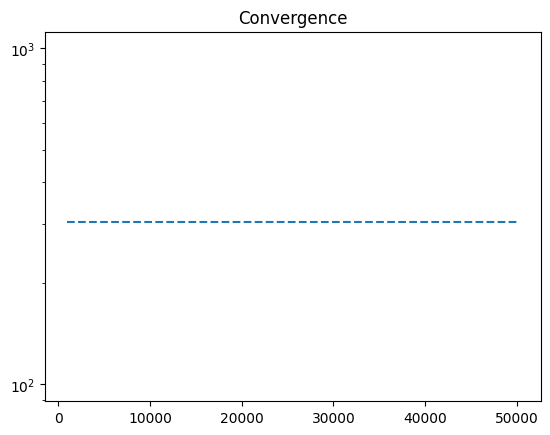

In [38]:
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.indicators.gd import GD
from pymoo.indicators.igd import IGD
import matplotlib.pyplot as plt
import numpy as np
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.termination import get_termination
from random import randint
from pymoo.termination.ftol import SingleObjectiveSpaceTermination
from pymoo.termination.robust import RobustTermination
from pymoo.termination.default import DefaultMultiObjectiveTermination

algorithm3 = BayesianOptimiztion()
res = minimize(get_problem("Griewank", n_var=20),
                algorithm3,
                save_history=True,
                termination=('n_eval', 50000),
                seed = 1,
                
                verbose=True)

pf = get_problem("Rastrigin", n_var=2).pareto_front()
print("PF",pf[0])
ind = GD(pf)
print("GD", ind(res.F))
ind2 = IGD(pf)
print("IGD", ind2(res.F))


n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])
print(opt)
plt.title("Convergence")
plt.plot(n_evals, opt, "--")
plt.plot(n_evals, np.repeat(pf[0],len(n_evals)), 'k-', lw=1,dashes=[2, 2])
plt.yscale("log")
plt.show()

In [250]:
model = GaussianProcessRegressor()
model.fit([[ -5.4380459   ,14.439186  ],
 [-32.76050433 ,-12.95433252],
 [-23.15020594 ,-26.71649785],
 [-20.56125079 ,-10.12133219],
 [ -6.76544681  , 2.54389348],
 [ -5.2956683   ,12.13854518],
 [-19.36901736  ,24.78030431],
 [-30.97312669  ,11.17175875],
 [ -5.41951247  , 3.8462966 ],
 [-23.56760159 ,-19.78522081]], [[20.06610928],
 [20.91157246],
 [21.37552947],
 [21.03260106],
 [14.87330739],
 [18.44667829],
 [21.70183449],
 [20.45546651],
 [14.04636827],
 [21.75295851]])
model.predict([[-20  ,6.44 ]])

array([[2.00627112e-30]])

In [17]:
np.array([234,25])**2

array([54756,   625], dtype=int32)